# Read in/transform Data

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

path_to_project = os.path.abspath(os.path.join(os.getcwd(), '../'))    
sys.path.insert(1, os.path.join(path_to_project))

In [2]:
import itertools
import pandas as pd
from sklearn.preprocessing import StandardScaler
from src.data_dict import *
from src.utils import one_hot
from src.directory import data_dir, NHANES_preprocessed_filename
from src.estimators import aipw_estimator, unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner

In [3]:
# load df
NHANES_preprocessed_filepath = os.path.join(data_dir, NHANES_preprocessed_filename)
df = pd.read_csv(NHANES_preprocessed_filepath, index_col='SEQN')

In [4]:
# define relevant features
# features
z_col = light_col
t_col = sleep_deprivation_col
y_cols = [htn_col, diastolic_col, systolic_col]

# columns not to transform
all_cols = df.columns
untransformed_cols = [x for x in all_cols if x in [*y_cols, t_col, z_col]]

In [5]:
# prune df
df.dropna(how='any', inplace=True)
df = df.query(f'age >= {age_cutoff}')

## transform df
# apply scalers
scaler = StandardScaler()
numerical_transformation_cols = list(set(numerical_cols) - set(untransformed_cols))
df[numerical_transformation_cols] = scaler.fit_transform(df[numerical_transformation_cols])

# make z col binary (indicator of recommended max lux value during sleep)
light_cutoff = 1 # nightly minute-mean summed light exposure
df[z_col] = df[z_col].apply(lambda x: 1 if x <= light_cutoff else x)
df[z_col] = df[z_col].apply(lambda x: 0 if x > light_cutoff else x)

# one-hot encode multiclass categoricals
multiclass_cols = df[categorical_cols].columns[df[categorical_cols].nunique() > 2].tolist() 
categorical_transformation_cols = list(set(multiclass_cols) - set(untransformed_cols))
df = one_hot(df, categorical_transformation_cols)
df.columns = df.columns.str.replace('.0', '')

# get df as float
df = df.astype(float)

# except treatment
df[t_col] = df[t_col].astype(int)

# get covariates
x_cols = list(set(df.columns) - set([*y_cols, t_col, z_col]))

# update lists of variable type
all_cols = df.columns
categorical_cols = [x for x in df.columns if any([x.startswith(y) for y in categorical_cols])]

In [6]:
tau_pairs = [' vs '.join(x[::-1]) for x in itertools.combinations(df[t_col].unique().astype(str), 2)]

# Non-Deep Learning Estimators

In [92]:
# created propensity score matched df
from src.utils import propensity_score_matching_multiclass, love_plot_multiclass_abs_compare

psm_df = propensity_score_matching_multiclass(df, t_col, x_cols)

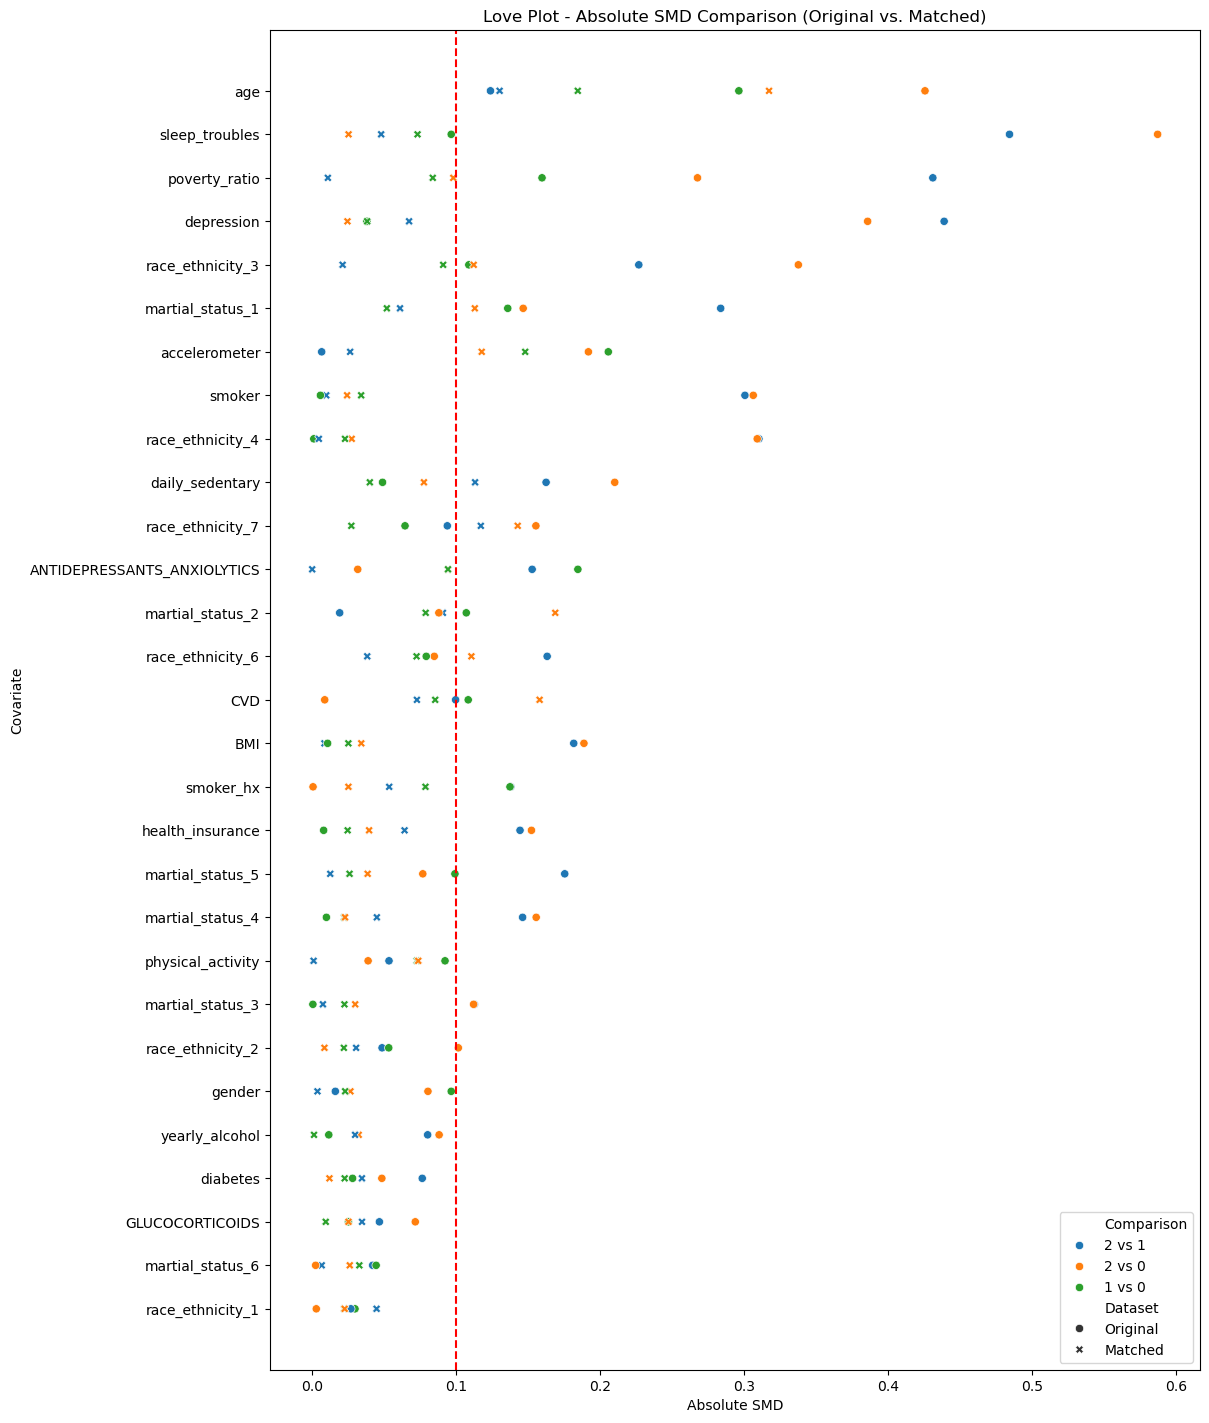

In [93]:
# Check balance between treatment groups in propensity matched vs. original dataset
love_plot_multiclass_abs_compare(df, psm_df, t_col, x_cols)

In [97]:
estimators = [aipw_estimator, unadjusted_DM_estimator, ipw_estimator, t_learner, s_learner, x_learner]  
estimator_names = estimator_names = [x.__name__ for x in estimators]
index = pd.MultiIndex.from_product([estimator_names, tau_pairs, y_cols], names=['estimator', 'pair','outcome'])
tau_results = pd.DataFrame(index=index, columns=['tau', 'propensity_model_score', 'outcome_model_score'])

In [99]:
for tau_estimator, outcome in itertools.product(estimators, y_cols):
    estimator_name = tau_estimator.__name__
    print(f'Estimating effect of {t_col} on {outcome} using {estimator_name}...')
    continuous_outcome = False if outcome == 'HTN' else True
    results = tau_estimator(psm_df, 
                            treatment_var=t_col,
                            outcome_var=outcome, 
                            covariates=x_cols,
                            continuous_outcome=continuous_outcome)
    
    for pair in results.keys():
        tau = results[pair]['tau']
        propensity_model_score = results[pair]['propensity_model_score']
        outcome_model_score = results[pair]['outcome_model_score']
        tau_results.loc[(estimator_name, pair, outcome)] = tau, propensity_model_score, outcome_model_score

Estimating effect of sleep_deprivation on HTN using aipw_estimator...
Estimating effect of sleep_deprivation on DBP using aipw_estimator...
Estimating effect of sleep_deprivation on SBP using aipw_estimator...
Estimating effect of sleep_deprivation on HTN using unadjusted_DM_estimator...
Estimating effect of sleep_deprivation on DBP using unadjusted_DM_estimator...
Estimating effect of sleep_deprivation on SBP using unadjusted_DM_estimator...
Estimating effect of sleep_deprivation on HTN using ipw_estimator...
Estimating effect of sleep_deprivation on DBP using ipw_estimator...
Estimating effect of sleep_deprivation on SBP using ipw_estimator...
Estimating effect of sleep_deprivation on HTN using t_learner...
Estimating effect of sleep_deprivation on DBP using t_learner...
Estimating effect of sleep_deprivation on SBP using t_learner...
Estimating effect of sleep_deprivation on HTN using s_learner...
Estimating effect of sleep_deprivation on DBP using s_learner...
Estimating effect of 

In [100]:
tau_results

tau propensity_model_score  \
estimator               pair   outcome                                     
aipw_estimator          1 vs 0 HTN      -0.013226               0.728421   
                               DBP      -0.392682               0.728421   
                               SBP      -0.431916               0.728421   
                        2 vs 0 HTN       0.001037               0.728421   
                               DBP      -0.732105               0.728421   
                               SBP       0.499705               0.728421   
                        2 vs 1 HTN       0.014263               0.728421   
                               DBP      -0.339422               0.728421   
                               SBP       0.931621               0.728421   
unadjusted_DM_estimator 1 vs 0 HTN      -0.048353                    NaN   
                               DBP       0.356298                    NaN   
                               SBP      -1.886831                    NaN   
                        2 vs 0 HTN      -0.046055                    NaN   
                               DBP       0.509708                    NaN   
                               SBP       0.093552                    NaN   
                        2 vs 1 HTN       0.002299                    NaN   
                               DBP        0.15341                    NaN   
                               SBP       1.980383                    NaN   
ipw_estimator           1 vs 0 HTN       0.004901               0.728421   
                               DBP        1.50816               0.728421   
                               SBP       2.418902               0.728421   
                        2 vs 0 HTN      -0.053326               0.728421   
                               DBP      -5.734914               0.728421   
                               SBP      -9.258401               0.728421   
                        2 vs 1 HTN      -0.058227               0.728421   
                               DBP      -7.243074               0.728421   
                               SBP     -11.677303               0.728421   
t_learner               1 vs 0 HTN            0.0                    NaN   
                               DBP            0.0                    NaN   
                               SBP            0.0                    NaN   
                        2 vs 0 HTN            0.0                    NaN   
                               DBP            0.0                    NaN   
                               SBP            0.0                    NaN   
                        2 vs 1 HTN            0.0                    NaN   
                               DBP            0.0                    NaN   
                               SBP            0.0                    NaN   
s_learner               1 vs 0 HTN      -0.009358                    NaN   
                               DBP      -0.223953                    NaN   
                               SBP       0.013259                    NaN   
                        2 vs 0 HTN       0.000298                    NaN   
                               DBP      -0.487225                    NaN   
                               SBP       0.917432                    NaN   
                        2 vs 1 HTN       0.009656                    NaN   
                               DBP      -0.263272                    NaN   
                               SBP       0.904172                    NaN   
x_learner               1 vs 0 HTN      -0.010614               0.728421   
                               DBP      -0.351545               0.728421   
                               SBP      -0.438648               0.728421   
                        2 vs 0 HTN      -0.001701               0.728421   
                               DBP      -0.463635               0.728421   
                               SBP       0.606237               0.728421   
                  

# Deep Learning Estimators

In [7]:
import pandas as pd
from src.lightning_pipelines import DragonNet_training_pipeline

Seed set to 40


In [11]:
# set training variables & labels
dataset_name = 'NHANES'
model_name = 'DragonNet'
treatment_col = t_col
n_treatment_groups = df[treatment_col].nunique()
outcome_cols = y_cols[0:1]
input_features = x_cols
input_dim = len(input_features)

# hyperparamters
alpha = 1.0
beta = 1.0
max_epochs = 250
patience = 10  # for early stopping
target_regs = [True, False]
learning_rates = {htn_col:1e-4, systolic_col:3e-4, diastolic_col:3e-4}

# logging params
wandb_kwargs = dict(project_name='CPH_200B', 
                    wandb_entity='furtheradu', 
                    dir_path='notebooks/..',
                    offline=True)

Seed set to 40


In [12]:
# set up results dataframe
target_reg_str = {True:'_target_reg', False:''}
estimator_names = [f'{model_name}{target_reg_str[x]}' for x in target_regs]
index = pd.MultiIndex.from_product([estimator_names, tau_pairs, outcome_cols], names=['estimator', 'pair','outcome'])
dragon_tau_results = pd.DataFrame(index=index, columns=['tau', 
                                                        'se', 
                                                        'propensity_model_score', 
                                                        'outcome_model_score']).sort_index()

In [13]:
for target_reg, outcome_col in itertools.product(target_regs, outcome_cols):
    print(f'Training model {model_name} on {dataset_name} with target_reg == {target_reg} to predict CATE of {treatment_col} on {outcome_col}')    
    pipeline_out = DragonNet_training_pipeline(
        raw_data=df,
        model_name=model_name,
        treatment_col=treatment_col,
        outcome_col=outcome_col,
        input_features=input_features,
        dataset_name=dataset_name,
        alpha=alpha,
        beta=beta,
        target_reg=target_reg,
        wandb_kwargs=wandb_kwargs,
        n_treatment_groups=n_treatment_groups,
        max_epochs=max_epochs,
        learning_rate=learning_rates[outcome_col],
        patience=patience
    )

    trainer, model, datamodule = [pipeline_out[x] for x in ['trainer', 'model', 'datamodule']]
    
    print("Testing model")
    test_pred = trainer.test(model, datamodule)
    
    # log results to df
    estimator_name = f'{model_name}{target_reg_str[target_reg]}'
    for pair in tau_pairs:
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'tau'] = test_pred[0][f'test_tau_{pair}']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'se'] = test_pred[0][f'test_se_{pair}']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'outcome_model_score'] = test_pred[0][f'test_outcome_model_mse']
        dragon_tau_results.loc[(estimator_name, pair, outcome_col), 'propensity_model_score'] = test_pred[0][f'test_propensity_model_bal_acc']
        
    print(f'Finished training.\n\n')

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph200b_project3/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Training model DragonNet on NHANES with target_reg == True to predict CATE of sleep_deprivation on HTN
Training model


Processing NHANES Dataset: 2547it [00:00, 19655.41it/s]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | DragonNetTorch | 118 K  | train
-------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.474     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing NHANES Dataset: 2547it [00:00, 6563.55it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

Using bfloat16 Automatic Mixed Precision (AMP)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_dragon_net_loss              1.3666185022887347
            test_loss                   1.9697278533918057
     test_outcome_model_mse             0.26743694609890595
  test_propensity_model_bal_acc         0.3436945378780365
         test_se_1 vs 0                  0.036098662763834
         test_se_2 vs 0                 0.03610138222575188
         test_se_2 vs 1                 0.03609934821724892
test_targeted_regularization_loss        0.603109351103071
         test_tau_1 vs 0               -0.07913248240947723
         test_tau_2 vs 0               -0.10590802878141403
         test_tau_2 vs 1                -0.0267755426466465
───────────────────────────────────────────────

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/hentipapai/miniconda3/envs/cph200b_project3/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Training model


Processing NHANES Dataset: 2547it [00:00, 9055.26it/s]

  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | DragonNetTorch | 118 K  | train
-------------------------------------------------
118 K     Trainable params
0         Non-trainable params
118 K     Total params
0.474     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing model


Processing NHANES Dataset: 2547it [00:00, 5838.95it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           Test metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_dragon_net_loss               1.272031198312239
            test_loss                   1.2720311880111694
     test_outcome_model_mse             0.24839155339010052
  test_propensity_model_bal_acc         0.3659749925136566
         test_se_1 vs 0                0.015167132019996643
         test_se_2 vs 0                0.015103563666343689
         test_se_2 vs 1                0.015101457946002483
test_targeted_regularization_loss               0.0
         test_tau_1 vs 0               -0.029276546090841293
         test_tau_2 vs 0               -0.09898800402879715
         test_tau_2 vs 1               -0.06971145421266556
────────────────────────────────────────────────────

In [ ]:
dragon_tau_results.dropna(how='all')

Seed set to 40


tau        se  \
estimator            pair   outcome                       
DragonNet            1 vs 0 HTN      0.137609  0.065195   
                     2 vs 0 HTN      0.167431  0.065181   
                     2 vs 1 HTN      0.029822  0.065181   
DragonNet_target_reg 1 vs 0 HTN      0.216838  0.015708   
                     2 vs 0 HTN      -0.24043  0.015708   
                     2 vs 1 HTN     -0.457269  0.015708   

                                    propensity_model_score outcome_model_score  
estimator            pair   outcome                                             
DragonNet            1 vs 0 HTN                    0.37352            0.238818  
                     2 vs 0 HTN                    0.37352            0.238818  
                     2 vs 1 HTN                    0.37352            0.238818  
DragonNet_target_reg 1 vs 0 HTN                   0.298877            0.290396  
                     2 vs 0 HTN                   0.298877            0.290396  
                     2 vs 1 HTN                   0.298877            0.290396